## Cluster Analysis

The COSMX protein data was previously run through a co-localization analysis which cells PMNs are physically near. This is used as a proxy for cell-cell interaction. The next step is to take that Z-score data results and run it through a clustering algorithum to determine if responders or nonresponders have different interaction profiles. Primarly use the python **sklearn** library.

#### Types of clustering methods
1. K-means: The kmeans algorithium clusters data by sperating the data into groups with equal variance. This is perhaps the most common method but can run into the issue of local mininum. Since it uses a least squared method of finding these centers of least variance it can find a local mininum even if there is a better location elsewhere. Works by essentially assigning centroids and then iterating by least squares to find location of minimum local variance.
2. Mean Shift:
3. Affinity Propagation:

### K Means Tutorial Long

We select a subset of 4 topics only accounting for around 3,400 documents. See the example Classification of text documents using sparse features to gain intuition on the overlap of such topics.

In [1]:
import numpy as np

from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


#### Quantifying the quality of clustering results



In [4]:
from collections import defaultdict
from time import time

from sklearn import metrics

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

vectorization done in 0.222 s
n_samples: 3387, n_features: 7929
0.007


In [27]:
from sklearn.cluster import KMeans

for seed in range(6,11):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements assigned to each cluster: [   1    7 3377    2]
Number of elements assigned to each cluster: [ 699 1833  252  603]
Number of elements assigned to each cluster: [3379    1    6    1]
Number of elements assigned to each cluster: [ 527  752 1863  245]
Number of elements assigned to each cluster: [  87  702  667 1931]

True number of documents in each category according to the class labels: [799 973 987 628]


In [9]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 0.11 ± 0.02 s 
Homogeneity: 0.349 ± 0.010
Completeness: 0.398 ± 0.009
V-measure: 0.372 ± 0.009
Adjusted Rand-Index: 0.203 ± 0.017
Silhouette Coefficient: 0.007 ± 0.000


In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.186 s
Explained variance of the SVD step: 18.4%


In [16]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:142

clustering done in 0.02 ± 0.00 s 
Homogeneity: 0.399 ± 0.015
Completeness: 0.435 ± 0.021
V-measure: 0.416 ± 0.017
Adjusted Rand-Index: 0.312 ± 0.026
Silhouette Coefficient: 0.030 ± 0.002


C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(


In [17]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=4097 ,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=14
  warnings.warn(
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=14
  warnings.warn(
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment vari

clustering done in 0.12 ± 0.03 s 
Homogeneity: 0.322 ± 0.090
Completeness: 0.362 ± 0.068
V-measure: 0.337 ± 0.078
Adjusted Rand-Index: 0.258 ± 0.114
Silhouette Coefficient: 0.021 ± 0.008


In [18]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: space nasa shuttle launch station program sci think like just 
Cluster 1: thanks graphics image file program files know looking help format 
Cluster 2: just like think don time know sure does good ve 
Cluster 3: god people don think jesus religion bible say believe christian 


In [19]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset.data)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 0.757 s


In [21]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(


clustering done in 0.02 ± 0.00 s 
Homogeneity: 0.393 ± 0.010
Completeness: 0.438 ± 0.018
V-measure: 0.414 ± 0.014
Adjusted Rand-Index: 0.311 ± 0.007
Silhouette Coefficient: 0.029 ± 0.000


C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(


In [22]:
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)

C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=14
  warnings.warn(
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=14
  warnings.warn(
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment vari

clustering done in 0.13 ± 0.03 s 
Homogeneity: 0.359 ± 0.036
Completeness: 0.378 ± 0.029
V-measure: 0.368 ± 0.032
Adjusted Rand-Index: 0.332 ± 0.030
Silhouette Coefficient: 0.026 ± 0.004


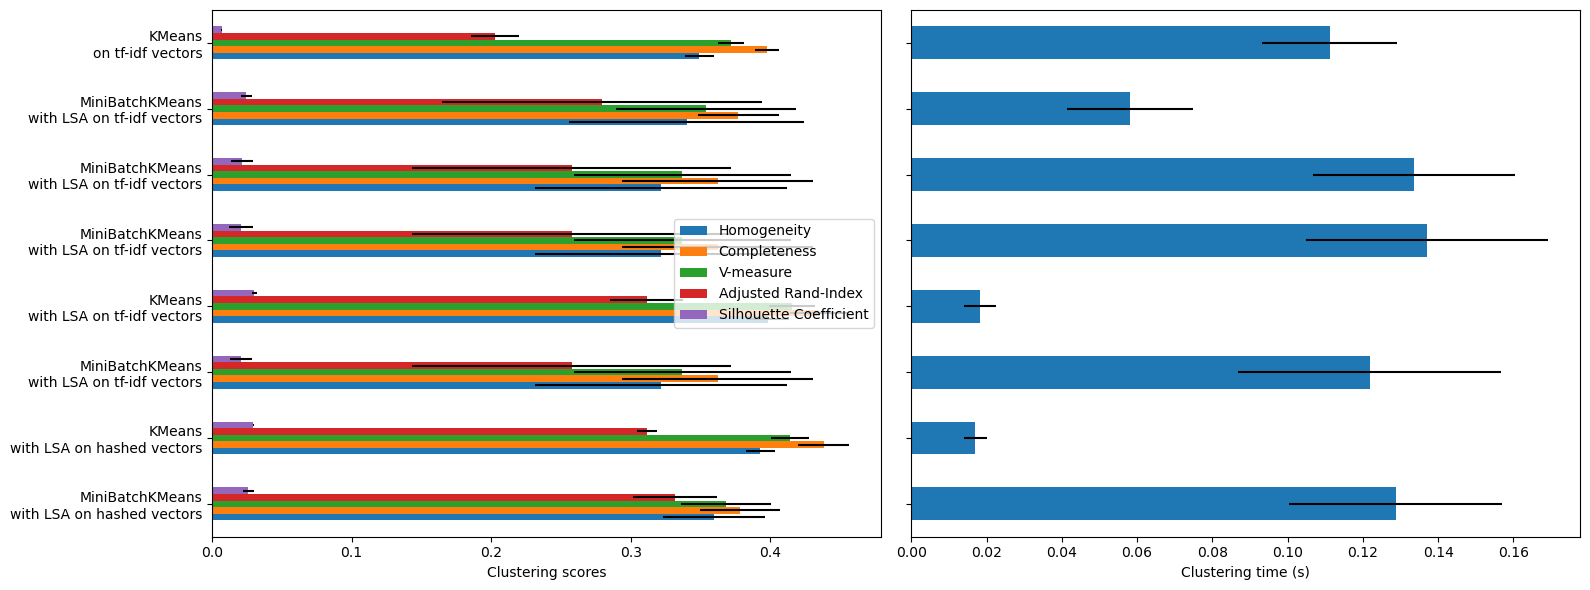

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

Automatically created module for IPython interactive environment


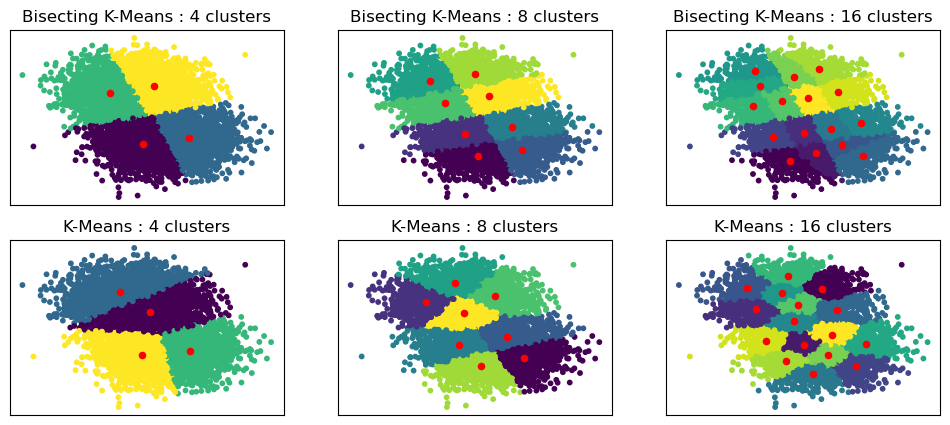

In [29]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt

from sklearn.cluster import BisectingKMeans, KMeans
from sklearn.datasets import make_blobs

print(__doc__)

# Generate sample data
n_samples = 10000
random_state = 0

X, _ = make_blobs(n_samples=n_samples, centers=2, random_state=random_state)

# Number of cluster centers for KMeans and BisectingKMeans
n_clusters_list = [4, 8, 16]

# Algorithms to compare
clustering_algorithms = {
    "Bisecting K-Means": BisectingKMeans,
    "K-Means": KMeans,
}

# Make subplots for each variant
fig, axs = plt.subplots(
    len(clustering_algorithms), len(n_clusters_list), figsize=(12, 5)
)
axs = axs.T
for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        algo = Algorithm(n_clusters=n_clusters, random_state=random_state, n_init=3)
        algo.fit(X)
        centers = algo.cluster_centers_

        axs[j, i].scatter(X[:, 0], X[:, 1], s=10, c=algo.labels_)
        axs[j, i].scatter(centers[:, 0], centers[:, 1], c="r", s=20)

        axs[j, i].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

### Basic K Means Tutorial



C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


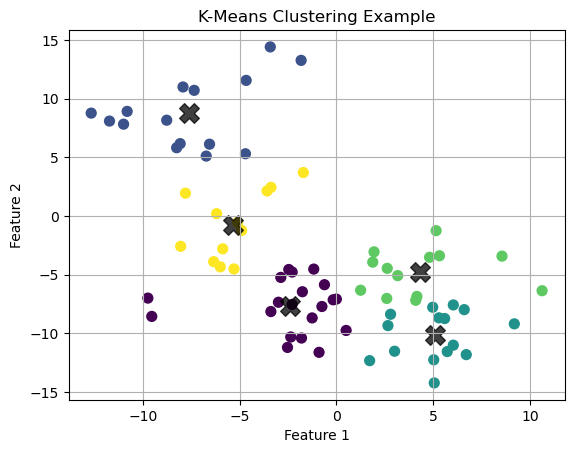

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Step 1: Generate sample data (100 points, 3 centers)
X, y_true = make_blobs(n_samples=75, centers=6, cluster_std=3, random_state=16)

# Step 2: Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Step 3: Plot the clustered data
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Step 4: Plot the centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75, marker='X')
plt.title("K-Means Clustering Example")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

### Load in Protein Data

In [3]:
#!pip install ipynb

Current working directory: C:\Users\ejohns\Documents\GitHub\2025-Dinh-Lab-Research-Project\Shapiro 2025 Project\Python SquidPy
Files: ['.ipynb_checkpoints', 'Cluster Analysis.ipynb', 'CosMX Protein Data Testing.ipynb', 'CosMX RNA Data Testing Full.ipynb', 'CosMX RNA Data Testing.ipynb', 'CosMX RNA Testing.ipynb', 'my_functions.ipynb', 'SquidPy Nature Paper.pdf', 'SquidPySpatialColocalizationPractice.ipynb', 'TutorialandPractice']


In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np

# Load files on Evan's Laptop
# expr_orig = pd.read_csv(r"C:\Users\evanj\OneDrive\Documents\expression.csv", index_col=0)
# expr=expr_orig.transpose()
# metadata = pd.read_csv(r"C:\Users\evanj\OneDrive\Documents\metadata.csv", index_col=0)
# umap = pd.read_csv(r"C:\Users\evanj\OneDrive\Documents\umap.csv", index_col=0)

#Load files on Lab computer
expr_orig = pd.read_csv(r"C:\Users\ejohns\Documents\Shapiro Data Files\expression.csv", index_col=0)
expr=expr_orig.transpose()
metadata = pd.read_csv(r"C:\Users\ejohns\Documents\Shapiro Data Files\metadata.csv", index_col=0)
umap = pd.read_csv(r"C:\Users\ejohns\Documents\Shapiro Data Files\umap.csv", index_col=0)

# Create AnnData object
adata = sc.AnnData(X=expr.values)

# Assign metadata
adata.obs = metadata
adata.var_names = expr.columns
adata.obs_names = expr.index

# Add spatial coordinates and UMAP to .obsm
# adata.obsm["spatial"] = metadata[['x_FOV_px', 'y_FOV_px']].values  # adjust if needed
adata.obsm["spatial"] = metadata[['x_FOV_px']].assign(y_FOV_px = -metadata['y_FOV_px']).values
adata.obsm["X_umap"] = umap.values

C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
C:\Users\ejohns\AppData\Local\anaconda3\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import annd

In [31]:
### Loop to get colocalization numbers for the Protein Data Sets
import pandas as pd
import importlib
import squidpy as sq
import my_functions

pmn_results = []
patient_ID=""
response_status=""
pmn_count=0

for y in range(1, 4):
    for x in range(1, 26):
        pmn_count=my_functions.pmn_counter(adata, f"c_{y}_{x}_")["PMN Count"]
        # Only run if there are PMNs present
        if pmn_count>1:
            results = my_functions.create_z_map(adata, y, x, 0)
            patient_ID=results["Patient ID"]
            response_status=results["Response Status"]
            pmn_count=results["PMN Count"]

            #Add Patient Meta Data to chart
            neutrophil_row = results["Z-Score Interaction Matrix"]["Neutrophils"]
            neutrophil_row["Run"] = f"TMA:{y}_Run{x}"
            neutrophil_row["Patient ID"] = patient_ID
            neutrophil_row["Response Status"] = response_status
            neutrophil_row["PMN #"]=pmn_count
            pmn_results.append(neutrophil_row)
  

# Convert to DataFrame
pmn_df = pd.DataFrame(pmn_results)

# Set index by run name (if added)
pmn_df = pmn_df.set_index("Run")

# Show result
display(pmn_df)


Outer loop: y=1
  Inner loop: x=1


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=2
  Inner loop: x=3


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=4


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=5


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=6


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=7


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=8


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=9


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=10


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=11


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=12


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=13


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=14


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=15


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=16


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=17


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=18


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=19


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=20


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=21


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=22


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=23


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=24


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=25


  0%|          | 0/1000 [00:00<?, ?/s]

Outer loop: y=2
  Inner loop: x=1


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=2


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=3


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=4


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=5


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=6


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=7


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=8


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=9


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=10


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=11


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=12


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=13


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=14


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=15


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=16


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=17


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=18


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=19


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=20


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=21


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=22


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=23


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=24


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=25


  0%|          | 0/1000 [00:00<?, ?/s]

Outer loop: y=3
  Inner loop: x=1
  Inner loop: x=2
  Inner loop: x=3


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=4


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=5


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=6


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=7


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=8


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=9


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=10


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=11


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=12
  Inner loop: x=13


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=14


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=15


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=16


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=17


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=18


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=19


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=20


  0%|          | 0/1000 [00:00<?, ?/s]

  Inner loop: x=21
  Inner loop: x=22
  Inner loop: x=23
  Inner loop: x=24
  Inner loop: x=25


,B_cells,CD4+T_cells,CD8+T_cells,Endothelial_cells,Fibroblasts/SMCs,Macrophages,Monocytes,Neutrophils,Plasma_cells,Tregs,Tumor_cells,Patient ID,Response Status,PMN #,DCs,NK_cells
Run,,,,,,,,,,,,,,,,
TMA:1_Run1,1.127257,1.018788,-0.786117,-6.015880,-4.139462,1.824205,15.309880,48.438268,15.214803,-0.308691,-7.776077,A,R,55,NaN,NaN
TMA:1_Run3,-0.229416,2.710784,-0.276877,-1.312520,-0.457187,2.721435,3.761980,7.386173,3.895480,-0.173190,1.107797,B,R,6,-0.294230,-0.123404
TMA:1_Run4,6.256938,7.168010,-0.966194,-2.379146,1.498804,1.419280,3.929986,6.469672,0.748647,3.754352,-1.213681,X,R,12,2.434371,-0.160581
TMA:1_Run5,-0.163383,-0.950238,1.028649,-0.511730,1.739395,0.725236,0.999165,19.476479,1.061827,-0.892008,-4.867589,X,R,15,2.852867,-0.377819
TMA:1_Run6,8.152251,28.315376,-0.253764,-5.202193,4.198596,NaN,NaN,42.854555,18.068765,6.120583,-12.328170,X,R,23,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMA:3_Run16,2.970857,3.649190,3.220644,NaN,11.675161,0.939901,1.487345,14.006605,8.489554,3.021207,-13.487380,L,NR,18,-0.491769,NaN
TMA:3_Run17,2.345631,2.703559,6.306095,NaN,3.190808,3.880621,0.002074,5.431243,9.217430,4.907017,-10.600478,L,NR,22,-1.023811,7.502835
TMA:3_Run18,-1.008425,-1.105249,0.433600,NaN,2.548274,1.938077,0.317956,5.269414,0.110246,-0.207827,-5.973117,H,NR,36,-0.394871,-0.473633


### Basic K-means Zscore Analysis

This is one of the most basic methods of doing cluster analysis. Form 2 groups with cluster analysis.

In [ ]:
# Removes unplottable alpha columns
pmn_numeric = pmn_df.drop(columns=['Patient ID', 'Response Status', 'PMN #']).copy()

# # Show result
# display(pmn_numeric)

##### Elbow Plot 

This forms an Elbow plot which may be useful in forming different groups

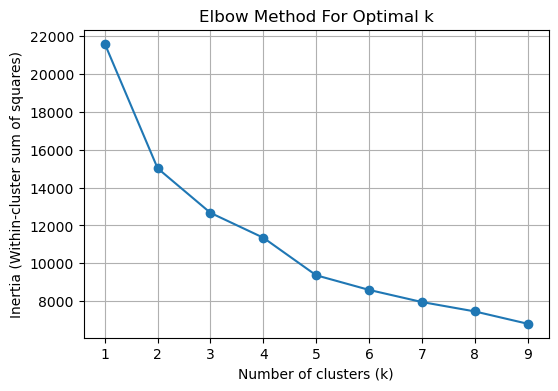

In [32]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")

# Fill NaNs with mean
pmn_df_filled = pmn_numeric.fillna(0)

# Now run KMeans
kmeans = KMeans(n_clusters=k, n_init=20, max_iter=300, random_state=42)
pmn_df_filled['Cluster'] = kmeans.fit_predict(pmn_df_filled)

# print(pmn_df_filled['Cluster'].value_counts())

inertia = []
k_range = range(1, 10)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(pmn_df_filled)
    inertia.append(km.inertia_)

# Plot the elbow curve
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.grid(True)
plt.show()

Cluster
2    21
0    17
3    11
1    10
4     7
Name: count, dtype: int64


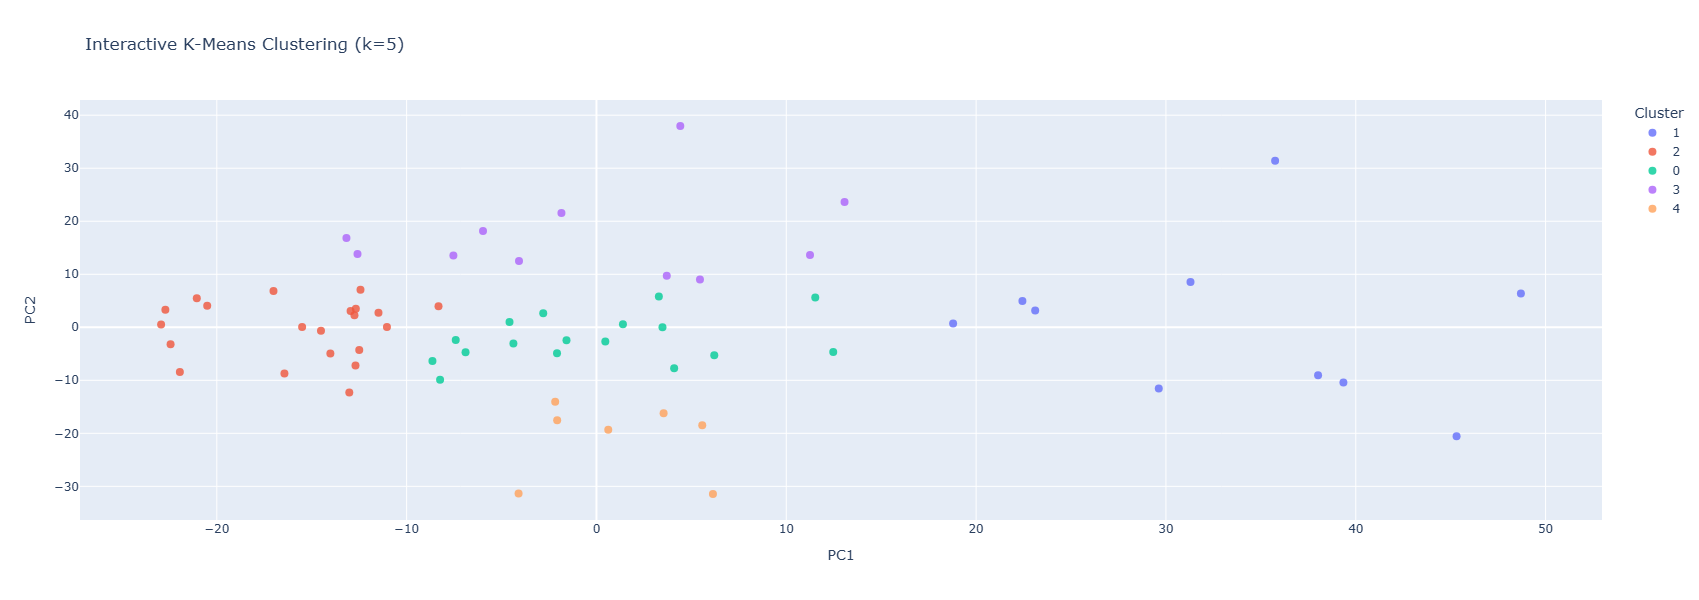

In [34]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px

# Step 1: Choose number of clusters (e.g., 3)
k = 5  # You can change this or use elbow method (shown below)

# Step 2: Fit KMeans
kmeans = KMeans(n_clusters=k, n_init=20, max_iter=300, random_state=42)
pmn_df_filled['Cluster'] = kmeans.fit_predict(pmn_df_filled)

# Step 3: Inspect cluster assignments
print(pmn_df_filled['Cluster'].value_counts())

# Step 4: Visualize clusters (e.g., using PCA for 2D view)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(pmn_df_filled.drop('Cluster', axis=1))
pmn_df_filled['PC1'] = components[:, 0]
pmn_df_filled['PC2'] = components[:, 1]

# Plot clusters
# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=pmn_df_filled, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60)
# plt.title(f'K-Means Clustering of PMN Expression (k={k})')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend(title='Cluster')
# plt.grid(True)
# plt.show()

pmn_df_filled2 = pd.concat([pmn_df_filled, pmn_df[['Patient ID', 'Response Status', 'PMN #']]], axis=1)

# pmn_df['Patient ID', 'Response Status', 'PMN #']
# Step 3: Interactive plot
fig = px.scatter(
    pmn_df_filled2,
    x='PC1',
    y='PC2',
    color=pmn_df_filled2['Cluster'].astype(str),
    title=f'Interactive K-Means Clustering (k={k})',
    labels={'color': 'Cluster'},
    hover_data=pmn_df_filled2.columns
)

fig.update_traces(marker=dict(size=8, opacity=0.8))
fig.update_layout(legend_title='Cluster')
fig.update_layout(width=900, height=600)
fig.show()

In [22]:
display(pmn_df_filled)

,B_cells,CD4+T_cells,CD8+T_cells,Endothelial_cells,Fibroblasts/SMCs,Macrophages,Monocytes,Neutrophils,Plasma_cells,Tregs,Tumor_cells,DCs,NK_cells,Cluster,PC1,PC2
Run,,,,,,,,,,,,,,,,
TMA:1_Run1,1.179986,1.162110,-0.813762,-6.041745,-3.892073,1.841735,15.256556,49.744022,14.644800,-0.285710,-7.824002,0.000000,0.000000,0,34.435459,4.514456
TMA:1_Run3,-0.212191,2.709438,-0.278960,-1.409429,-0.478016,2.749295,4.030681,8.713385,3.764254,-0.160128,1.063150,-0.311205,-0.119159,4,-8.789614,4.989676
TMA:1_Run4,5.827183,7.510707,-0.901824,-2.484115,1.596596,1.301918,4.114024,7.832889,0.755285,4.045199,-1.311578,2.342286,-0.181818,4,-9.014359,1.589650
TMA:1_Run5,-0.172818,-1.001138,1.060447,-0.483805,1.774052,0.627714,1.085462,19.346558,0.925416,-0.861793,-4.529346,2.881688,-0.358309,3,2.324118,4.110232
TMA:1_Run6,8.077914,29.775099,-0.322403,-5.146703,4.138747,0.000000,0.000000,42.170971,17.630756,6.827814,-11.841353,0.000000,0.000000,0,27.823932,-7.371929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMA:3_Run16,3.169609,3.521515,3.052325,0.000000,12.370897,1.019821,1.488401,13.149920,8.454029,2.824383,-13.531526,-0.504021,0.000000,1,-1.462947,-12.396179
TMA:3_Run17,2.247789,2.973257,6.597231,0.000000,3.121074,4.052258,-0.006552,5.289356,8.974803,4.997828,-10.489173,-1.119087,7.159197,4,-9.206826,-8.697913
TMA:3_Run18,-1.069035,-1.116770,0.471786,0.000000,2.596496,1.945007,0.348755,5.192591,0.133415,-0.204827,-5.976817,-0.384698,-0.460649,4,-10.964055,0.038247
